In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
from sklearn.calibration import calibration_curve

import pickle
from sklearn.metrics import accuracy_score, f1_score
from matplotlib.gridspec import GridSpec
from sklearn.calibration import CalibrationDisplay

In [31]:
# Suppress the SettingWithCopyWarning
pd.set_option('mode.chained_assignment', None)
pd.set_option('future.no_silent_downcasting', True)
warnings.simplefilter(action='ignore', category=FutureWarning)

In [32]:
# Load data from the CSV file
df_snapshot = pd.read_csv('../feature-mart/customer_behavior_ecom_snapshot_FRM.csv')

In [33]:
# Get the test data
df_snapshot_truncate = df_snapshot[(df_snapshot.time_snapshot<='2011-12-1')] 
df_snapshot_truncate['is_churn_future_1_month'] = df_snapshot_truncate.num_successful_orders_future_1_month==0

time_split = '2011-11-01'
df_test = df_snapshot_truncate[df_snapshot_truncate.time_snapshot==time_split]

In [34]:
df_test.is_churn_future_1_month.value_counts(normalize=True)

is_churn_future_1_month
True     0.653367
False    0.346633
Name: proportion, dtype: float64

In [35]:
# Define the features and target 
features = ['customer_id', 
            'total_successful_amount_past_5_month', 'num_successful_orders_past_5_month',
            'total_successful_amount_past_4_month', 'num_successful_orders_past_4_month',
            'total_successful_amount_past_3_month', 'num_successful_orders_past_3_month', 
            'total_successful_amount_past_2_month', 'num_successful_orders_past_2_month',
            'total_successful_amount_past_1_month', 'num_successful_orders_past_1_month',
            'recency', 'frequency', 'monetary', 'FrequencyScore', 'MonetaryScore', 'RecencyScore']
target = 'is_churn_future_1_month'

In [36]:
# Load model from pickel file
filename = '../models/churn_model_logistics.pkl'
with open(filename, 'rb') as f:
    churn_model = pickle.load(f)

In [37]:
churn_model.predict_proba(df_test[features])[:,1]

array([0.45753537, 0.37797741, 0.4950671 , ..., 0.81436959, 0.76086735,
       0.74170931])

Model test Accuracy: 0.702
Model F1 Score: 0.809


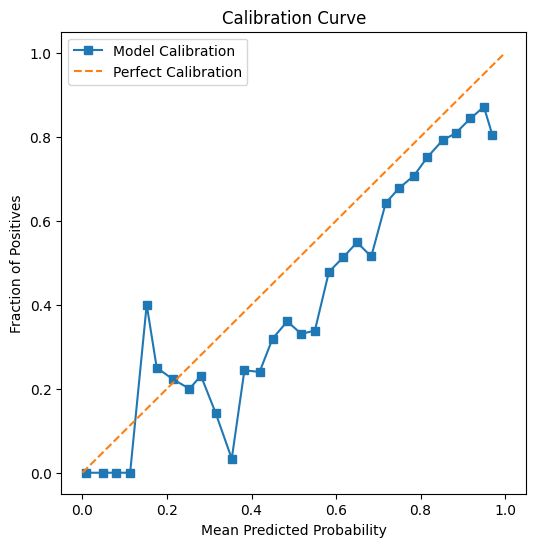

In [38]:
y_test = df_test[target]
y_pred = churn_model.predict_proba(df_test)[:,1]
y_pred = y_pred>=0.5
print(f"Model test Accuracy: {accuracy_score(y_test, y_pred):.3f}")
print(f"Model F1 Score: {f1_score(y_test, y_pred):.3f}")

# print("Accuracy on training set: {:.3f}".format(model.score(X_train, y_train)))
# print("Accuracy on test set: {:.3f}".format(model.score(X_test, y_test)))
# Make predictions
y_pred = churn_model.predict_proba(df_test)[:,1]

# Compute calibration curve
fraction_of_positives, mean_predicted_value = calibration_curve(y_test, y_pred, n_bins=30)

# Plot calibration curve
plt.figure(figsize=(6, 6))
plt.plot(mean_predicted_value, fraction_of_positives, "s-", label="Model Calibration")
plt.plot([0, 1], [0, 1], "--", label="Perfect Calibration")
plt.xlabel("Mean Predicted Probability")
plt.ylabel("Fraction of Positives")
plt.title("Calibration Curve")
plt.legend()
plt.show()

(array([  23.,   15.,   29.,   80.,  194.,  357.,  517.,  692.,  957.,
        1146.]),
 array([1.91604716e-09, 9.71793065e-02, 1.94358611e-01, 2.91537916e-01,
        3.88717220e-01, 4.85896525e-01, 5.83075829e-01, 6.80255134e-01,
        7.77434438e-01, 8.74613743e-01, 9.71793048e-01]),
 <BarContainer object of 10 artists>)

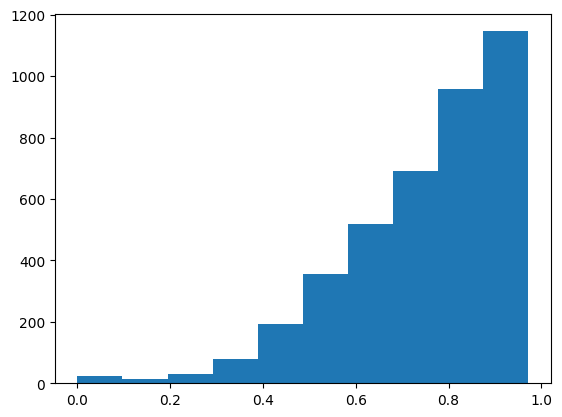

In [39]:
plt.hist(y_pred)

In [40]:
# Recall all models 
with open("../models/churn_model_logistics.pkl", 'rb') as f:
    churn_model_logistics = pickle.load(f)

with open("../models/churn_model_randomforest.pkl", 'rb') as f:
    churn_model_randomforest = pickle.load(f)

with open("../models/churn_model_gradientboosting.pkl", 'rb') as f:
    churn_model_gradientboosting = pickle.load(f)

with open("../models/churn_model_catboost.pkl", 'rb') as f:
    churn_model_catboost = pickle.load(f)

In [41]:
lst_model =[
    (churn_model_logistics, "Logistic Regression"),
    (churn_model_randomforest, "Random Forest"),
    (churn_model_gradientboosting, "Gradient Boosting"),
    (churn_model_catboost, "CatBoost")
]

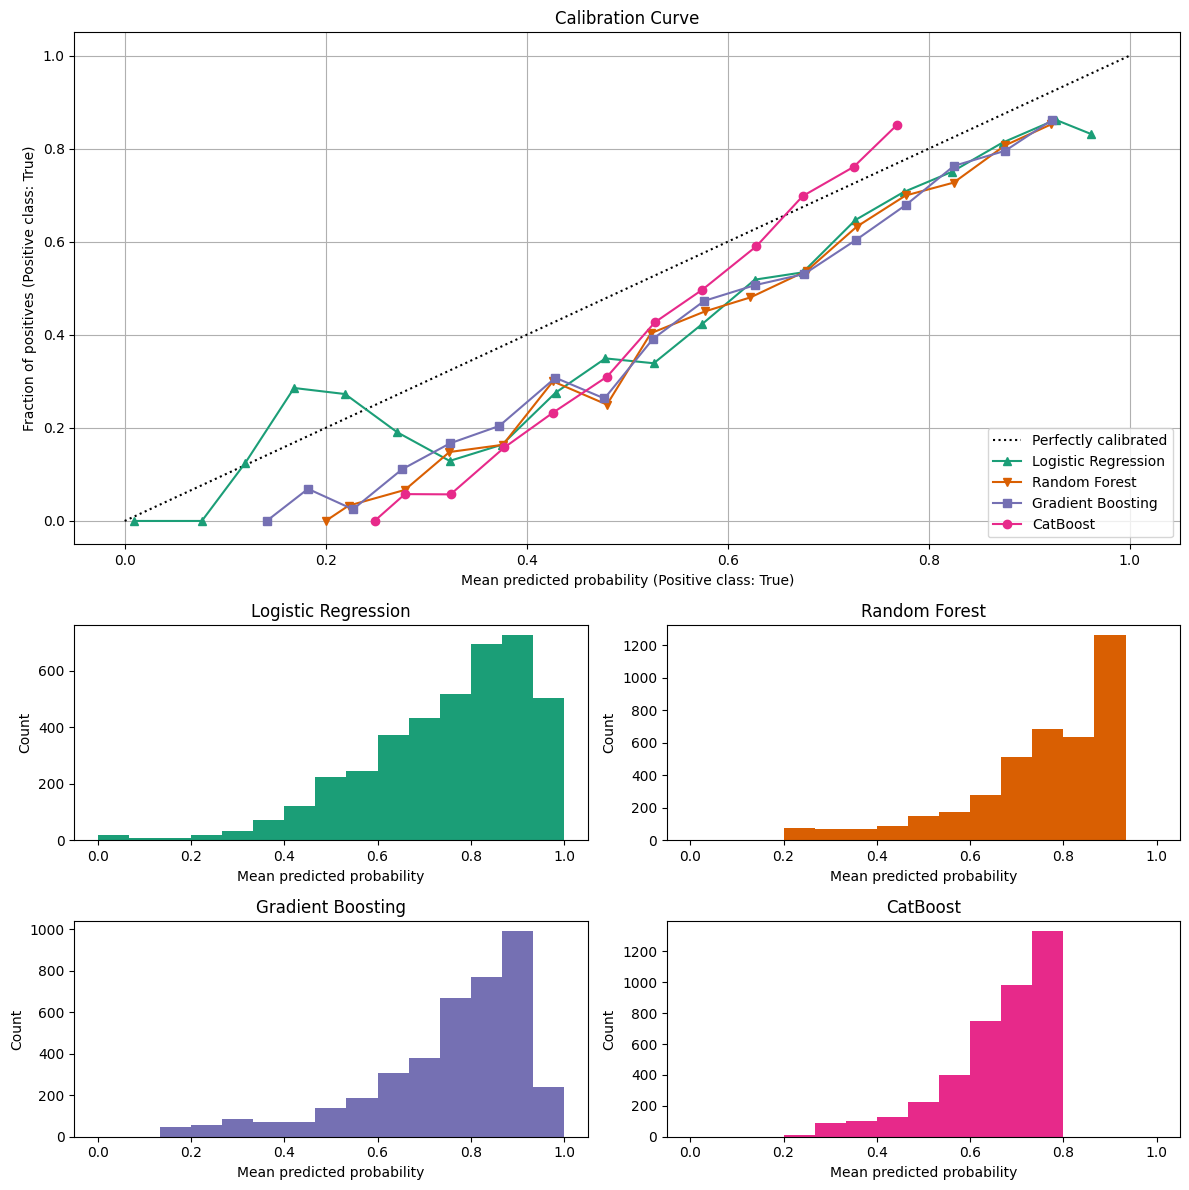

In [42]:
# Plot the calibration curve with the histogram of the predicted probabilities
fig = plt.figure(figsize=(12,12))
gs = GridSpec(4, 2)
colors = plt.get_cmap("Dark2")

# Calibration curve
ax_calibration_curve = fig.add_subplot(gs[:2, :2])
calibration_displays = {}
markers = ["^", "v", "s", "o"]
for i, (model, name) in enumerate(lst_model):
    display = CalibrationDisplay.from_estimator(model, 
                                df_test,
                                y_test, 
                                ax=ax_calibration_curve, 
                                name=name,
                                n_bins=20, 
                                marker=markers[i], 
                                color=colors(i))
    calibration_displays[name] = display

ax_calibration_curve.grid()
ax_calibration_curve.set_title("Calibration Curve")

# Add histogram of the predicted probabilities
grid_positions = [(2,0), (2,1), (3,0), (3,1)]
for i, (_, name) in enumerate(lst_model):
    row, col = grid_positions[i]
    ax = fig.add_subplot(gs[row, col])
    ax.hist(calibration_displays[name].y_prob, 
            bins=15, 
            color=colors(i),           
            range=(0, 1))
    ax.set(title=name, xlabel="Mean predicted probability", ylabel="Count")

plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Churn Rate Over Time')

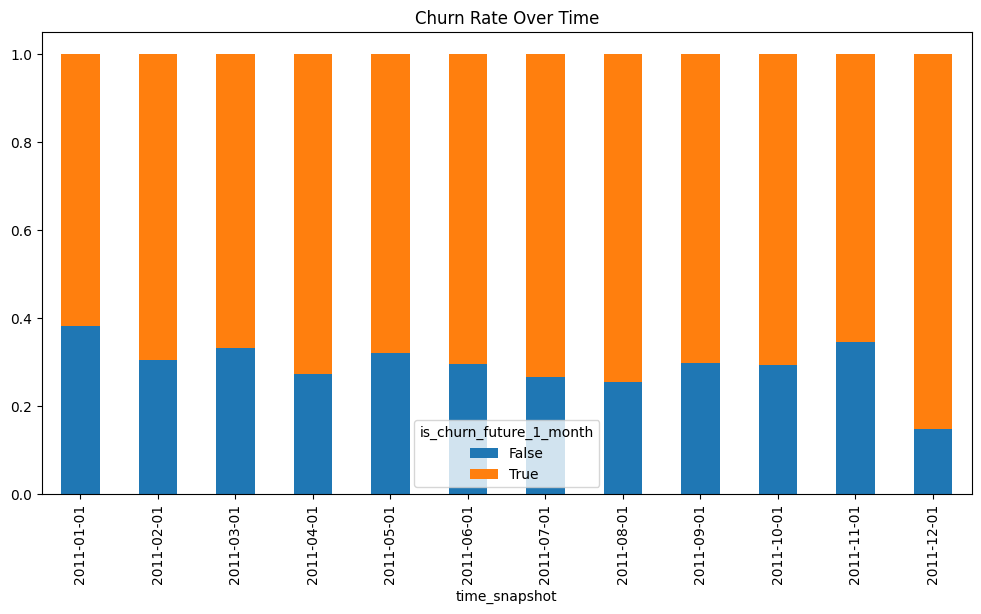

In [43]:
df_snapshot_truncate.groupby("time_snapshot")["is_churn_future_1_month"].value_counts(normalize=True).unstack().plot(kind="bar", stacked=True, figsize=(12, 6))
plt.title("Churn Rate Over Time")

In [44]:
df_snapshot_truncate.groupby("time_snapshot")["is_churn_future_1_month"].value_counts(normalize=True)

time_snapshot  is_churn_future_1_month
2011-01-01     True                       0.618143
               False                      0.381857
2011-02-01     True                       0.694668
               False                      0.305332
2011-03-01     True                       0.668382
               False                      0.331618
2011-04-01     True                       0.725902
               False                      0.274098
2011-05-01     True                       0.678457
               False                      0.321543
2011-06-01     True                       0.705096
               False                      0.294904
2011-07-01     True                       0.732845
               False                      0.267155
2011-08-01     True                       0.745381
               False                      0.254619
2011-09-01     True                       0.701190
               False                      0.298810
2011-10-01     True                       0

In [45]:
y_pred_prob = churn_model.predict_proba(df_test[features])[:,1]
df_test["churn_prob"] = y_pred_prob
df_test["churn_pred"] = y_pred_prob>=0.5
df_error = df_test[df_test.is_churn_future_1_month!=df_test.churn_pred]#.sort_values("churn_prob")

In [46]:
df_error.head(20)

,customer_id,total_successful_amount_past_5_month,num_successful_orders_past_5_month,total_successful_amount_past_4_month,num_successful_orders_past_4_month,total_successful_amount_past_3_month,num_successful_orders_past_3_month,total_successful_amount_past_2_month,num_successful_orders_past_2_month,total_successful_amount_past_1_month,...,time_snapshot,recency,frequency,monetary,RecencyScore,FrequencyScore,MonetaryScore,is_churn_future_1_month,churn_prob,churn_pred
24723,12347.0,382.52,18.0,0.00,0.0,584.91,22.0,0.00,0.0,1294.32,...,2011-11-01,0,171,4085.18,5,5,5,True,0.457535,False
24724,12359.0,1109.32,47.0,0.00,0.0,0.00,0.0,0.00,0.0,2876.85,...,2011-11-01,18,250,6336.78,4,5,5,True,0.377977,False
24725,12360.0,0.00,0.0,0.00,0.0,534.70,30.0,0.00,0.0,1043.78,...,2011-11-01,13,129,2662.06,5,5,5,True,0.495067,False
24730,12380.0,607.55,36.0,0.00,0.0,0.00,0.0,626.01,28.0,446.61,...,2011-11-01,7,88,1680.17,5,4,4,False,0.587982,True
24731,12381.0,NaN,NaN,NaN,NaN,1227.39,66.0,0.00,0.0,10.50,...,2011-11-01,19,68,1237.89,4,4,4,False,0.620779,True
24733,12395.0,163.90,10.0,0.00,0.0,165.95,7.0,0.00,0.0,346.68,...,2011-11-01,27,115,2228.45,4,5,5,False,0.575057,True
24741,12427.0,0.00,0.0,0.00,0.0,0.00,0.0,0.00,0.0,282.58,...,2011-11-01,21,28,529.13,4,3,3,False,0.748716,True
24744,12432.0,4016.66,76.0,0.00,0.0,0.00,0.0,0.00,0.0,1042.66,...,2011-11-01,3,108,5059.32,5,4,5,True,0.452552,False
24746,12437.0,501.64,13.0,0.00,0.0,0.00,0.0,557.28,24.0,263.46,...,2011-11-01,4,124,3242.72,5,5,5,False,0.522037,True
24752,12456.0,0.00,0.0,1325.23,45.0,-27.15,4.0,0.00,0.0,915.64,...,2011-11-01,5,129,3153.89,5,5,5,True,0.477580,False


In [50]:
churn_model.named_steps["classifier"].coef_

array([[-0.00165024, -0.02951216, -0.05034405, -0.08229708, -0.03436293,
        -0.0747504 , -0.06557948, -0.07775815, -0.08895313, -0.12714097,
        -0.06980546,  0.72330937,  0.00185556, -0.18621107, -0.08119534,
        -0.4218542 ,  0.03954722]])

In [ ]:
churn_model.named_steps["classifier"]

array([1.52770418])

In [59]:
churn_model.get_feature_names_out

<bound method Pipeline.get_feature_names_out of Pipeline(steps=[('feature_selection',
                 ColumnTransformer(transformers=[('select_features',
                                                  'passthrough',
                                                  ['customer_id',
                                                   'total_successful_amount_past_5_month',
                                                   'num_successful_orders_past_5_month',
                                                   'total_successful_amount_past_4_month',
                                                   'num_successful_orders_past_4_month',
                                                   'total_successful_amount_past_3_month',
                                                   'num_successful_orders_past_3_month',
                                                   'tota...t_past_2_month',
                                                   'num_successful_orders_past_2_month',
         